In [1]:
# --- Feature Importance & Pricing Model ---
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.pyplot as plt

In [2]:
# Load and clean the dataset
df = pd.read_csv("data/gym_floor_raw.csv")

In [3]:
# Drop Quoted_Price from training set to avoid feature leakage
if "Quoted_Price" in df.columns:
    df.drop(columns=["Quoted_Price"], inplace=True)

In [4]:
# Drop non-numeric or irrelevant columns
df.drop(columns=["Name", "Account#", "Location", "GP", "GYMLABORAP"], errors='ignore', inplace=True)

# Encode categorical variables
label_enc = LabelEncoder()
df["AM"] = label_enc.fit_transform(df["AM"])

In [7]:
# Drop rows with missing values
df.dropna(inplace=True)

# Define features and target
y = df["GP_Percent"]
X = df.drop(columns=["GP_Percent"])

In [8]:
# Save feature column names
X_columns = list(X.columns)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Train model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [10]:
# Save model artifacts
joblib.dump(rf, "model_rf.pkl")
joblib.dump(label_enc, "label_encoder.pkl")
joblib.dump(X_columns, "X_columns.pkl")

['X_columns.pkl']

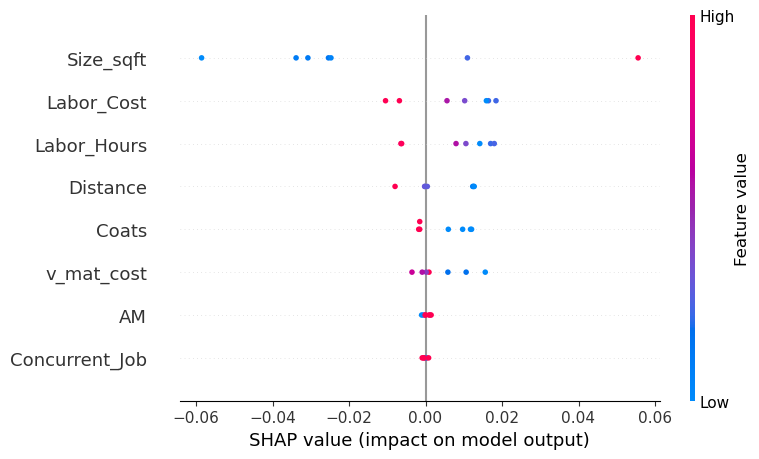

In [11]:
# SHAP analysis
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

In [12]:
# Define a function to simulate GP% for a range of quotes
def simulate_pricing(input_data, model, target_gp=0.45, quote_range=np.arange(0.30, 2.00, 0.01)):
    base_features = pd.DataFrame([input_data])
    sqft = input_data["Size_sqft"]
    coats = input_data["Coats"]

    # Define minimum rate per sqft
    if coats == 1:
        min_rate = 0.48
    elif coats == 2:
        min_rate = 0.67
    else:
        raise ValueError("Unsupported number of coats")

    # Filter quote range based on minimum rate
    quote_range = quote_range[quote_range >= min_rate]

    for rate in quote_range:
        quote = round(rate * sqft, 2)
        test_row = base_features.copy()
        test_row["Quoted_Price"] = quote
        test_row = test_row.reindex(columns=X_columns, fill_value=0)
        gp_pred = model.predict(test_row)[0]

        if gp_pred >= target_gp:
            return {
                "Recommended Price": quote,
                "Rate per sqft": rate,
                "Predicted GP%": gp_pred
            }

    return {
        "Recommended Price": None,
        "Rate per sqft": None,
        "Predicted GP%": None
    }

In [13]:
# --- Export Notebook to .py File ---
import subprocess
notebook_name = "feature_importance.ipynb"
output_script = "feature_importance"
subprocess.run(["jupyter", "nbconvert", "--to", "script", notebook_name, "--output", output_script])
print(f"Notebook '{notebook_name}' exported to '{output_script}.py'")

Notebook 'feature_importance.ipynb' exported to 'feature_importance.py'
